# Feature Selection Using Genetic Algorithms

#### In this notebook, we present the implementation of the feature selection using GA, the results of the search, and the list of features to be used for training

Install necessary dependencies

In [ ]:
!pip install -r ../req.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.0 MB/s eta 0:00:00


Start with the existing pipeline

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
from pyswarms.single import GlobalBestPSO
from functools import partial
from typing import Dict, List, Tuple, Union, Optional


# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


class ModelPipeline:
    """
    A flexible, modular pipeline for feature selection,
    models tuning, and training.

    Attributes:
        data_path (str): path to the dataset (Pandas parquet)
        sample_frac (float): part of a dataset used for training
        X (np.array): feature vectors
        Y (np.array): labels
        selected_features (List[str]): list of selected features
        scaler ()
        X_train, X_test, y_train, y_test (np.array's): train and test dataset splits
        models (List[Dict]): list of dictionaries describing models
    """

    def __init__(self, data_path: str, selected_features=None, sample_frac: float = 1.0):
        """Initialize the pipeline with data loading"""
        self.data_path = data_path
        self.sample_frac = sample_frac
        self.selected_features = selected_features
        self._load_data()
        self.scaler = None
        self.models = {
            'RandomForest': {
                'tune_func': self.tune_random_forest,
                'train_func': self.train_random_forest,
                'params': None
            },
            'XGBoost': {
                'tune_func': self.tune_xgboost,
                'train_func': self.train_xgboost,
                'params': None
            },
            'LightGBM': {
                'tune_func': self.tune_lightgbm,
                'train_func': self.train_lightgbm,
                'params': None
            },
            'DenseNN': {
                'tune_func': self.tune_dense_nn,
                'train_func': self.train_dense_nn,
                'params': None
            }
        }

    def _random_undersample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """Undersample dataset for binary labels"""
        a_label, b_label = y.unique()
        a_label_cnt, b_label_cnt = y.value_counts()
        minority_label = a_label if (a_label_cnt < b_label_cnt) else b_label
        majority_label = b_label if (a_label_cnt < b_label_cnt) else a_label
        minority_cnt = a_label_cnt if (a_label_cnt < b_label_cnt) else b_label_cnt

        # Select all elements with minority label
        minority_y = y[y == minority_label]
        new_X = X.loc[minority_y.index]
        new_y = minority_y

        # Sample elements with majority label
        majority_y = y[y == majority_label]
        sampled_majority = majority_y.sample(n=minority_cnt, random_state=42)
        new_X = pd.concat([new_X, X.loc[sampled_majority.index]])
        new_y = pd.concat([new_y, sampled_majority])

        return new_X, new_y

    def _load_data(self) -> None:
        """Load and prepare data"""
        X = pd.read_parquet(self.data_path)
        y = X['remainder__isFraud']
        X = X.drop(columns=['remainder__isFraud'])

        """Prepare train/test split and optionally select features"""
        if self.selected_features is not None:
            X = X.iloc[:, self.selected_features]

        self.X = X
        self.y = y

        # Data split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Undersampling for equal proportion of labels
        self.X_train, self.y_train = self._random_undersample(X_train, y_train)
        self.X_test, self.y_test = X_test, y_test

        # Take a sample using sample_frac
        if self.sample_frac < 1.0:
            self.X_train = self.X_train.sample(frac=self.sample_frac, random_state=42)
            self.y_train = self.y_train.loc[self.X_train.index]

    def evaluate_features(self, individual, X_train, y_train, X_val, y_val) -> Tuple[float]:
        """Evaluate fitness of feature subset using RandomForest"""
        selected = [i for i, val in enumerate(individual) if val == 1]

        if not selected:  # At least one feature must be selected
            return 0.0,

        X_train_sub = X_train.iloc[:, selected]
        X_val_sub = X_val.iloc[:, selected]

        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=5,
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_train_sub, y_train)
        y_proba = model.predict_proba(X_val_sub)[:, 1]
        score = roc_auc_score(y_val, y_proba)

        # Add penalty for too many features
        feature_penalty = len(selected) / X_train.shape[1] * 0.1
        return score - feature_penalty,

    def genetic_feature_selection(self, n_pop: int = 50, n_gen: int = 20,
                                  cxpb: float = 0.5, mutpb: float = 0.2) -> List[int]:
        """Perform feature selection using Genetic Algorithm"""
        # Split data for feature selection
        X_train, X_val, y_train, y_val = train_test_split(
            self.X_train, self.y_train, test_size=0.2, stratify=self.y_train, random_state=42
        )

        # DEAP setup
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_bool, n=self.X.shape[1])
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        eval_fn = partial(self.evaluate_features,
                          X_train=X_train, y_train=y_train,
                          X_val=X_val, y_val=y_val)
        toolbox.register("evaluate", eval_fn)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Run GA
        pop = toolbox.population(n=n_pop)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)

        pop, log = algorithms.eaSimple(
            pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=n_gen,
            stats=stats, halloffame=hof, verbose=True
        )

        best_individual = hof[0]
        selected_features = [i for i, val in enumerate(best_individual) if val == 1]

        print(f"\nSelected {len(selected_features)} features out of {self.X.shape[1]}")
        print("Selected feature indices:", selected_features)

        self.selected_features = selected_features
        return selected_features

    # ==================== Random Forest ====================
    def tune_random_forest(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for Random Forest hyperparameters"""

        bounds = (
            np.array([50, 2, 2, 1]),    # min values
            np.array([500, 30, 10, 30])  # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                n_estimators = int(param_set[0])
                max_depth = int(param_set[1])
                min_samples_split = int(param_set[2])
                max_features = min(int(param_set[3]), self.X_train.shape[1])

                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    class_weight='balanced_subsample',
                    n_jobs=-1,
                    random_state=42
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'n_estimators': int(best_params[0]),
            'max_depth': int(best_params[1]),
            'min_samples_split': int(best_params[2]),
            'max_features': int(best_params[3])
        }

        print("\nOptimized Random Forest Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['RandomForest']['params'] = optimized_params
        return optimized_params

    def train_random_forest(self) -> Dict[str, Union[float, str]]:
        """Train Random Forest with optimized parameters"""
        if not self.models['RandomForest']['params']:
            raise ValueError("Random Forest parameters not tuned. Call tune_random_forest() first.")

        params = self.models['RandomForest']['params']
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            max_features=params['max_features'],
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        return self._evaluate_model(model, "Random Forest")

    # ==================== XGBoost ====================
    def tune_xgboost(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for XGBoost hyperparameters"""

        bounds = (
            np.array([0.01, 3, 0.1, 0.1, 0.1, 0]),  # min values
            np.array([0.3, 10, 10, 1, 1, 5])        # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                model = XGBClassifier(
                    learning_rate=param_set[0],
                    max_depth=int(param_set[1]),
                    min_child_weight=param_set[2],
                    subsample=param_set[3],
                    colsample_bytree=param_set[4],
                    gamma=param_set[5],
                    scale_pos_weight=np.sqrt(len(self.y_train)/self.y_train.sum()),
                    tree_method='hist',
                    eval_metric='aucpr',
                    random_state=42
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'learning_rate': best_params[0],
            'max_depth': int(best_params[1]),
            'min_child_weight': best_params[2],
            'subsample': best_params[3],
            'colsample_bytree': best_params[4],
            'gamma': best_params[5]
        }

        print("\nOptimized XGBoost Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['XGBoost']['params'] = optimized_params
        return optimized_params

    def train_xgboost(self) -> Dict[str, Union[float, str]]:
        """Train XGBoost with optimized parameters"""
        if not self.models['XGBoost']['params']:
            raise ValueError("XGBoost parameters not tuned. Call tune_xgboost() first.")

        params = self.models['XGBoost']['params']
        model = XGBClassifier(
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            min_child_weight=params['min_child_weight'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            gamma=params['gamma'],
            scale_pos_weight=np.sqrt(len(self.y_train)/self.y_train.sum()),
            tree_method='hist',
            eval_metric='aucpr',
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        return self._evaluate_model(model, "XGBoost")

    # ==================== LightGBM ====================
    def tune_lightgbm(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for LightGBM hyperparameters"""

        bounds = (
            np.array([0.01, 3, 0.1, 0.1, 0.1, 20]),  # min values
            np.array([0.3, 50, 100, 1, 1, 50])       # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                model = LGBMClassifier(
                    learning_rate=param_set[0],
                    num_leaves=int(param_set[1]),
                    min_data_in_leaf=int(param_set[2]),
                    feature_fraction=param_set[3],
                    bagging_fraction=param_set[4],
                    bagging_freq=int(param_set[5]),
                    class_weight='balanced',
                    boosting_type='gbdt',
                    objective='binary',
                    random_state=42
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(self.X_train, self.y_train):
                    X_train_cv, X_val_cv = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'learning_rate': best_params[0],
            'num_leaves': int(best_params[1]),
            'min_data_in_leaf': int(best_params[2]),
            'feature_fraction': best_params[3],
            'bagging_fraction': best_params[4],
            'bagging_freq': int(best_params[5])
        }

        print("\nOptimized LightGBM Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['LightGBM']['params'] = optimized_params
        return optimized_params

    def train_lightgbm(self) -> Dict[str, Union[float, str]]:
        """Train LightGBM with optimized parameters"""
        if not self.models['LightGBM']['params']:
            raise ValueError("LightGBM parameters not tuned. Call tune_lightgbm() first.")

        params = self.models['LightGBM']['params']
        model = LGBMClassifier(
            learning_rate=params['learning_rate'],
            num_leaves=params['num_leaves'],
            min_data_in_leaf=params['min_data_in_leaf'],
            feature_fraction=params['feature_fraction'],
            bagging_fraction=params['bagging_fraction'],
            bagging_freq=params['bagging_freq'],
            class_weight='balanced',
            boosting_type='gbdt',
            objective='binary',
            random_state=42
        )

        model.fit(self.X_train, self.y_train)
        return self._evaluate_model(model, "LightGBM")

    # ==================== Dense Neural Network ====================
    def _create_dense_nn(self, input_dim: int, layers: Tuple[int, ...] = (64, 32),
                         learning_rate: float = 0.001, dropout_rate: float = 0.2) -> Sequential:
        """Create a dense neural network architecture"""
        model = Sequential()
        model.add(Input((input_dim,)))
        model.add(Dense(layers[0], activation='relu'))
        model.add(Dropout(dropout_rate))

        for units in layers[1:]:
            model.add(Dense(units, activation='relu'))
            model.add(Dropout(dropout_rate))

        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def tune_dense_nn(self, n_particles: int = 5, iters: int = 10) -> Dict[str, float]:
        """PSO optimization for Dense NN hyperparameters"""

        # Scale data for NN
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(self.X_train)

        bounds = (
            np.array([0.0001, 16, 16, 0.1, 0.1]),  # min values
            np.array([0.01, 256, 256, 0.5, 0.5])   # max values
        )

        def objective_function(params):
            scores = []
            for param_set in params:
                model = KerasClassifier(
                    model=lambda: self._create_dense_nn(
                        input_dim=X_train_scaled.shape[1],
                        layers=(int(param_set[1]), int(param_set[2])),
                        learning_rate=param_set[0],
                        dropout_rate=param_set[4]
                    ),
                    epochs=10,
                    batch_size=256,
                    verbose=0
                )

                cv_scores = []
                cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

                for train_idx, val_idx in cv.split(X_train_scaled, self.y_train):
                    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
                    y_train_cv, y_val_cv = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]

                    model.fit(X_train_cv, y_train_cv)
                    y_proba = model.predict_proba(X_val_cv)[:, 1]
                    score = roc_auc_score(y_val_cv, y_proba)
                    cv_scores.append(score)

                scores.append(-np.mean(cv_scores))

            return np.array(scores)

        optimizer = GlobalBestPSO(
            n_particles=n_particles,
            dimensions=len(bounds[0]),
            options={'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'early_stop': True, 'patience': 3},
            bounds=bounds
        )

        best_cost, best_params = optimizer.optimize(objective_function, iters=iters)

        optimized_params = {
            'learning_rate': best_params[0],
            'layer1': int(best_params[1]),
            'layer2': int(best_params[2]),
            'dropout_rate': best_params[4]
        }

        print("\nOptimized Dense NN Parameters:")
        print(optimized_params)
        print(f"Best ROC-AUC: {-best_cost:.4f}")

        self.models['DenseNN']['params'] = optimized_params
        return optimized_params

    def train_dense_nn(self) -> Dict[str, Union[float, str]]:
        """Train Dense NN with optimized parameters"""
        if not self.models['DenseNN']['params']:
            raise ValueError("Dense NN parameters not tuned. Call tune_dense_nn() first.")

        params = self.models['DenseNN']['params']

        # Scale data
        X_train_scaled = self.scaler.transform(self.X_train)

        model = KerasClassifier(
            model=lambda: self._create_dense_nn(
                input_dim=X_train_scaled.shape[1],
                layers=(params['layer1'], params['layer2']),
                learning_rate=params['learning_rate'],
                dropout_rate=params['dropout_rate']
            ),
            epochs=50,
            batch_size=256,
            verbose=0
        )

        model.fit(X_train_scaled, self.y_train)
        return self._evaluate_model(model, "Dense Neural Network", is_nn=True)

    # ==================== Evaluation ====================
    def _evaluate_model(self, model, model_name: str, is_nn: bool = False,
                        X_test: Optional[np.ndarray] = None) -> Dict[str, Union[float, str]]:
        """Evaluate model performance and create visualizations"""
        if X_test is None:
            X_test = self.X_test

        if is_nn:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba > 0.5).astype(int)
        else:
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

        # Metrics calculation
        metrics = {
            "roc_auc": roc_auc_score(self.y_test, y_proba),
            "pr_auc": average_precision_score(self.y_test, y_proba),
            "classification_report": classification_report(self.y_test, y_pred)
        }

        if not is_nn and hasattr(model, 'feature_importances_'):
            metrics["feature_importance"] = model.feature_importances_

        # Visualization
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ConfusionMatrixDisplay.from_predictions(self.y_test, y_pred, ax=ax[0])
        ax[0].set_title(f"Confusion Matrix - {model_name}")

        if not is_nn and hasattr(model, 'feature_importances_'):
            # Top 10 most valuable features
            top_features = self.X.columns[
                np.argsort(metrics.get('feature_importance', np.zeros(self.X.shape[1])))[-10:]
            ]
            ax[1].barh(top_features, metrics.get('feature_importance', np.zeros(self.X.shape[1]))[-10:])
            ax[1].set_title(f"Top 10 Features - {model_name}")
        else:
            ax[1].axis('off')

        fig.tight_layout()

        plt.show()

        return metrics

    def run_pipeline(self, models_to_run: List[str] = None,
                     selected_features: List[int] = None) -> Dict[str, Dict[str, Union[float, str]]]:
        """
        Run the complete pipeline with optional model selection

        Args:
            models_to_run: List of model names to run (None for all)
            feature_selection: Whether to perform feature selection

        Returns:
            Dictionary of results for each model
        """
        if models_to_run is None:
            models_to_run = list(self.models.keys())

        # Perform feature selection if requested
        if selected_features is None:
            self.selected_features = list(range(self.X.shape[1]))

        results = {}

        for model_name in models_to_run:
            if model_name not in self.models:
                print(f"Warning: Model {model_name} not found in available models. Skipping.")
                continue

            print(f"\n=== Processing {model_name} ===")

            # Tune hyperparameters
            print(f"Tuning {model_name} hyperparameters...")
            self.models[model_name]['tune_func']()

            # Train model with optimized parameters
            print(f"Training {model_name} with optimized parameters...")
            results[model_name] = self.models[model_name]['train_func']()

            # Print results
            print(f"\n{model_name} Results:")
            print(f"ROC-AUC: {results[model_name]['roc_auc']:.4f}")
            print(f"PR-AUC: {results[model_name]['pr_auc']:.4f}")
            print("Classification Report:")
            print(results[model_name]['classification_report'])

        return results


In [2]:
pipeline = ModelPipeline(
    data_path='fraud_data.parquet',
    sample_frac=1.0
)

Initiate GA for feature selection

In [3]:
print("Starting Genetic Algorithm for feature selection...")
features = pipeline.genetic_feature_selection(n_gen=20)
print(features)

Starting Genetic Algorithm for feature selection...
gen	nevals	avg     	min     	max     
0  	50    	0.783033	0.768537	0.798525
1  	27    	0.789116	0.776887	0.800251
2  	25    	0.792288	0.783586	0.800366
3  	31    	0.795489	0.786729	0.80327 
4  	28    	0.797379	0.78371 	0.805504
5  	22    	0.799488	0.793027	0.806443
6  	40    	0.801186	0.793939	0.806443
7  	25    	0.802933	0.794492	0.807327
8  	33    	0.803136	0.795936	0.807327
9  	25    	0.80362 	0.79351 	0.806865
10 	26    	0.804404	0.797343	0.806865
11 	29    	0.805023	0.797112	0.809949
12 	31    	0.805205	0.7996  	0.809949
13 	18    	0.806242	0.799943	0.809949
14 	31    	0.806239	0.799104	0.809949
15 	31    	0.806326	0.798611	0.809949
16 	24    	0.80711 	0.799711	0.809949
17 	21    	0.808274	0.800374	0.809949
18 	30    	0.808829	0.802443	0.809949
19 	34    	0.807883	0.800761	0.809949
20 	26    	0.808826	0.80084 	0.809949

Selected 155 features out of 392
Selected feature indices: [2, 4, 8, 9, 12, 13, 14, 15, 16, 23, 24, 27, 28, 34,

Plot fitness change over generations

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
results = np.array([
  [0.783033,	0.768537,	0.798525],
  [0.789116,	0.776887,	0.800251],
  [0.792288,	0.783586,	0.800366],
  [0.795489,	0.786729,	0.80327 ],
  [0.797379,	0.78371 ,	0.805504],
  [0.799488,	0.793027,	0.806443],
  [0.801186,	0.793939,	0.806443],
  [0.802933,	0.794492,	0.807327],
  [0.803136,	0.795936,	0.807327],
  [0.80362 ,	0.79351 ,	0.806865],
  [0.804404,	0.797343,	0.806865],
  [0.805023,	0.797112,	0.809949],
  [0.805205,	0.7996  ,	0.809949],
  [0.806242,	0.799943,	0.809949],
  [0.806239,	0.799104,	0.809949],
  [0.806326,	0.798611,	0.809949],
  [0.80711 ,	0.799711,	0.809949],
  [0.808274,	0.800374,	0.809949],
  [0.808829,	0.802443,	0.809949],
  [0.807883,	0.800761,	0.809949],
  [0.808826,	0.80084 ,	0.809949]
])

Text(0, 0.5, 'Fitness score (ROC-AUC)')

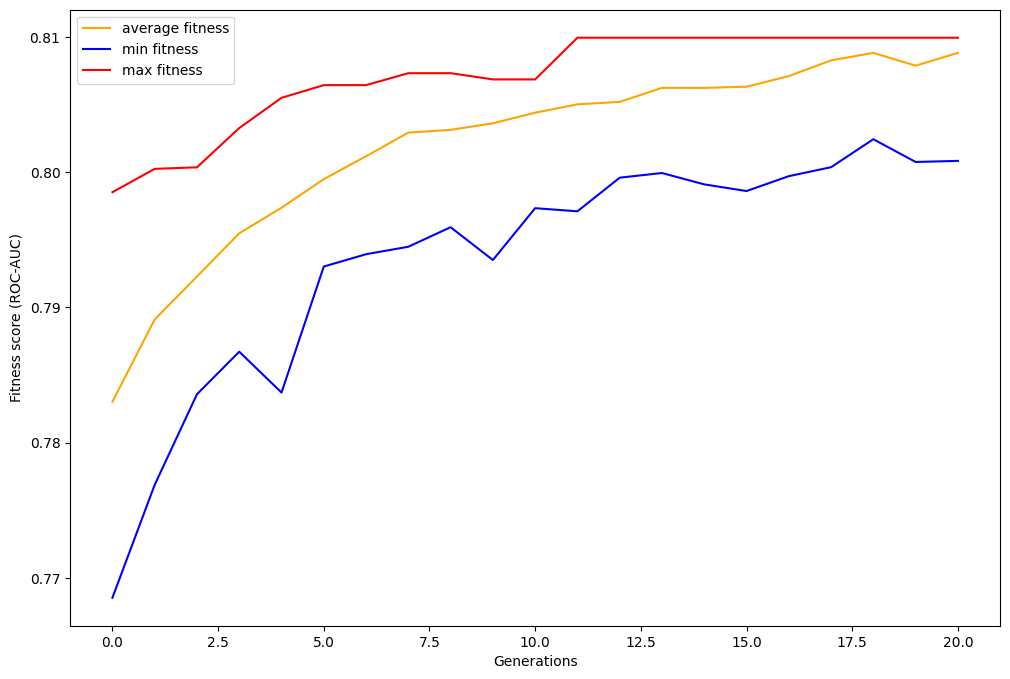

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(0, 21, 1), results[:, 0], color='orange')
ax.plot(np.arange(0, 21, 1), results[:, 1], color='blue')
ax.plot(np.arange(0, 21, 1), results[:, 2], color='red')

ax.legend(['average fitness', 'min fitness', 'max fitness'])
ax.set_xlabel('Generations')
ax.set_ylabel('Fitness score (ROC-AUC)')